In [69]:
import pandas as pd
import datetime
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set()
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.labelpad'] = 10
mpl.rc('text', usetex=True)
plt.style.use('ggplot')

In [2]:
%load_ext version_information
%version_information pandas, matplotlib, seaborn

Software versions
Python 3.6.5 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.4.0
OS Darwin 16.7.0 x86_64 i386 64bit
pandas 0.23.0
matplotlib 2.2.2
seaborn 0.9.0
Sun Nov 25 21:34:30 2018 PST

# Crypto Inflation Rates - Dev Notebook

Goals:
- Compare inflation rates for the top cryptocurrencies
- Highlight inflation rate changes for e.g. ETH

## Global functions

## Currencies

### BTC

In [50]:
def btc_block_supply_curve(
    premine_amount=0,
    inflation_change_blocks=210000,
    inflation_change_frac=0.5,
    ):
    out = [
        # Block num,
        # Total supply,
    ]
    y = premine_amount
    block = 0
    while True:
        block += 1
        num_changes = int(
            (block - 1) / inflation_change_blocks
        )
        if num_changes > 32:
            break
        block_reward = 50 * (
            inflation_change_frac ** num_changes
        )
        if (block - 1) % inflation_change_blocks == 0:
            print(
                f'Inflation change #{num_changes}, '
                f'block reward = {block_reward}'
            )
        y += block_reward
        out.append([block, y])

    return out

In [51]:
def datetime_supply_curve(
    start_date,
    block_time,
    block_supply,
    ):
    df = pd.DataFrame(
        block_supply, columns=['block', 'total_supply']
    )
    df['total_supply_pct'] = (
        df['total_supply'] / df['total_supply'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=block_time,
        periods=len(df)
    )
    return df

In [52]:
def plot_supply_curve(
    supply,
    coin_name,
    plot_pct=True,
    max_size=10000,
    ):
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    if plot_pct:
        values = supply.total_supply_pct.values[::step_size]
    else:
        values = supply.total_supply.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt='-',
        lw=4,
        label='supply curve',
    )
    
    # Plot current date
    mask = supply.date > datetime.datetime.now()
    current_supply = supply[mask].iloc[0]
    dates = mpl.dates.date2num([current_supply.date])
    if plot_pct:
        values = [current_supply.total_supply_pct]
    else:
        values = [current_supply.total_supply]
    plt.plot(
        dates,
        values,
        'o',
        color='black',
        ms=6,
        label=current_supply.date.strftime('%Y'),
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ total supply',
        y=1.05
    )
    plt.legend()
    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
    plt.savefig(
        f'../charts/{coin_name}.png',
        bbox_inches='tight',
        dpi=300
    )
    return plt

In [53]:
# BTC parameters
start_date = datetime.date(2009, 1, 3)
block_time = datetime.timedelta(seconds=60 * 10)

block_supply = btc_block_supply_curve()

btc_supply = datetime_supply_curve(
    start_date=start_date,
    block_time=block_time,
    block_supply=block_supply,
)

Inflation change #0, block reward = 50.0
Inflation change #1, block reward = 25.0
Inflation change #2, block reward = 12.5
Inflation change #3, block reward = 6.25
Inflation change #4, block reward = 3.125
Inflation change #5, block reward = 1.5625
Inflation change #6, block reward = 0.78125
Inflation change #7, block reward = 0.390625
Inflation change #8, block reward = 0.1953125
Inflation change #9, block reward = 0.09765625
Inflation change #10, block reward = 0.048828125
Inflation change #11, block reward = 0.0244140625
Inflation change #12, block reward = 0.01220703125
Inflation change #13, block reward = 0.006103515625
Inflation change #14, block reward = 0.0030517578125
Inflation change #15, block reward = 0.00152587890625
Inflation change #16, block reward = 0.000762939453125
Inflation change #17, block reward = 0.0003814697265625
Inflation change #18, block reward = 0.00019073486328125
Inflation change #19, block reward = 9.5367431640625e-05
Inflation change #20, block reward 

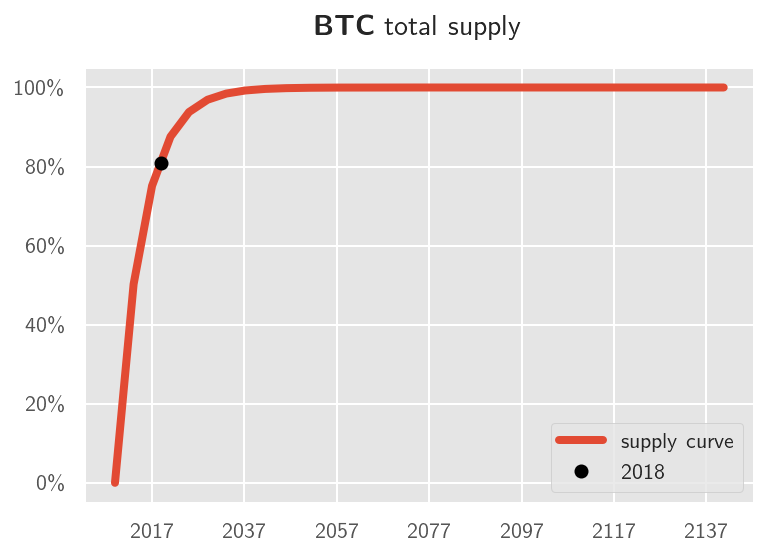

In [54]:
plot_supply_curve(
    btc_supply,
    'BTC',
);

### ETH

In [80]:
def eth_block_supply_curve(
    num_blocks,
    premine_amount=(72 * 1e6),
    output_granularity=10000,
    ):
    out = [
        # Block num,
        # Total supply - Original whitepaper,
        # Total supply - Current plan,
    ]
    
    # Get original block reward by 
    # taking 26% of 60M premine, and
    # dividing by 2102400 blocks per
    # year (assuming 15 second blocks)
    whitepaper_block_reward = 7.42
    
    # Start "current plan" block reward
    # as original
    current_block_reward = whitepaper_block_reward
    
    y_1 = premine_amount
    y_2 = premine_amount
    for block in tqdm_notebook(range(1, num_blocks+1)):
        if block == 2700000:
            # Adjust to 5 ETH block reward
            # quoted in EIP-186
            current_block_reward = 5
        elif block == 3700000:
            # Adjust to 4 ETH block reward
            # as per EIP-186
            current_block_reward = 4
        elif block == 5000000:
            # Adjust to 3 ETH block reward
            # as per EIP-186
            current_block_reward = 3
        elif block == 7000000:
            # Adjust to 2 ETH block reward
            # as per EIP-186
            current_block_reward = 2
        elif block > 8000000:
            # Adjust to 1.5% annual
            # ETH block reward for PoS
            current_block_reward = (
                (y_2 * 0.015) / 2102400
            )
        
        y_1 += whitepaper_block_reward
        y_2 += current_block_reward
        
        if (block-1) % output_granularity == 0:
            out.append([block, y_1, y_2])

    return out

In [81]:
def datetime_eth_supply_curve(
    start_date,
    block_time,
    block_supply,
    output_granularity=10000,
    ):
    df = pd.DataFrame(
        block_supply, columns=['block', 'original_whitepaper', 'current_plan']
    )
    df['original_whitepaper_pct'] = (
        df['original_whitepaper'] / df['original_whitepaper'].values[-1]
        * 100
    )
    df['current_plan_pct'] = (
        df['current_plan'] / df['current_plan'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=block_time * output_granularity,
        periods=len(df)
    )
    return df

In [87]:
def plot_eth_supply_curve(
    supply,
    coin_name='ETH',
    plot_pct=False,
    max_size=10000,
    out_name='',
    ):
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    # Original whitepaper
    if plot_pct:
        values = supply.original_whitepaper_pct.values[::step_size]
    else:
        values = supply.original_whitepaper.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt='-',
        lw=4,
        label='original whitepaper',
    )
    
    # Current plan
    if plot_pct:
        values = supply.current_plan_pct.values[::step_size]
    else:
        values = supply.current_plan.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt='-',
        lw=4,
        label='current plan',
    )
    
    # Plot current date
    mask = supply.date > datetime.datetime.now()
    current_supply = supply[mask].iloc[0]
    dates = mpl.dates.date2num([current_supply.date])
    if plot_pct:
        values = [current_supply.current_plan_pct]
    else:
        values = [current_supply.current_plan]
    plt.plot(
        dates,
        values,
        'o',
        color='black',
        ms=6,
        label=current_supply.date.strftime('%Y'),
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ total supply',
        y=1.05
    )
    plt.legend()
    
    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
    if not out_name:
        out_name = coin_name
    plt.savefig(
        f'../charts/{out_name}.png',
        bbox_inches='tight',
        dpi=300
    )
    return plt

In [82]:
# ETH parameters
start_date = datetime.date(2015, 7, 30)
end_date = datetime.date(2140, 10, 7)
block_time = datetime.timedelta(seconds=15)

num_blocks = int(
    ((end_date - start_date).days * 24 * 3600)
    / block_time.seconds
)

block_supply = eth_block_supply_curve(
    num_blocks=num_blocks,
)

eth_supply = datetime_eth_supply_curve(
    start_date=start_date,
    block_time=block_time,
    block_supply=block_supply,
)

NameError: name 'plot_eth_supply_curve' is not defined

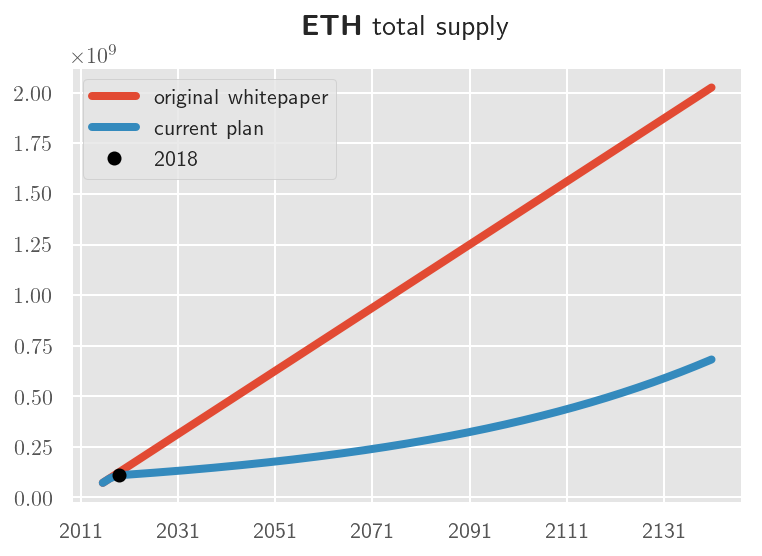

In [86]:
plot_eth_supply_curve(eth_supply);

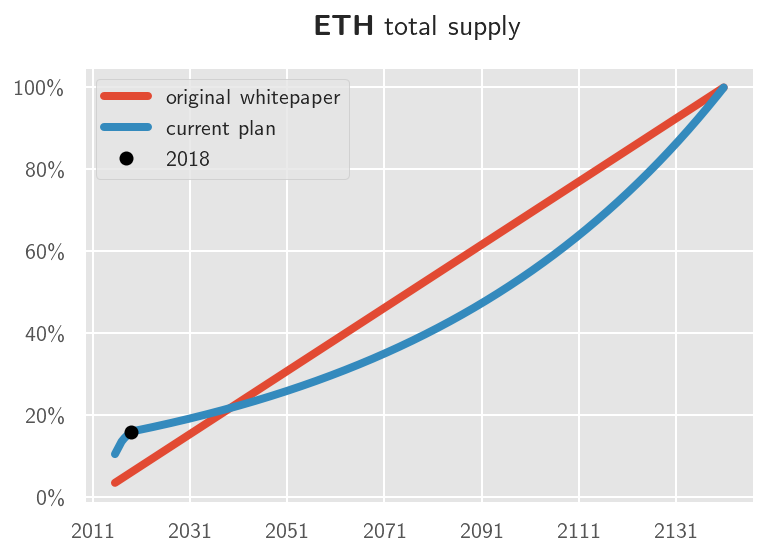

In [99]:
plot_eth_supply_curve(eth_supply, plot_pct=True, out_name='ETH_pct');

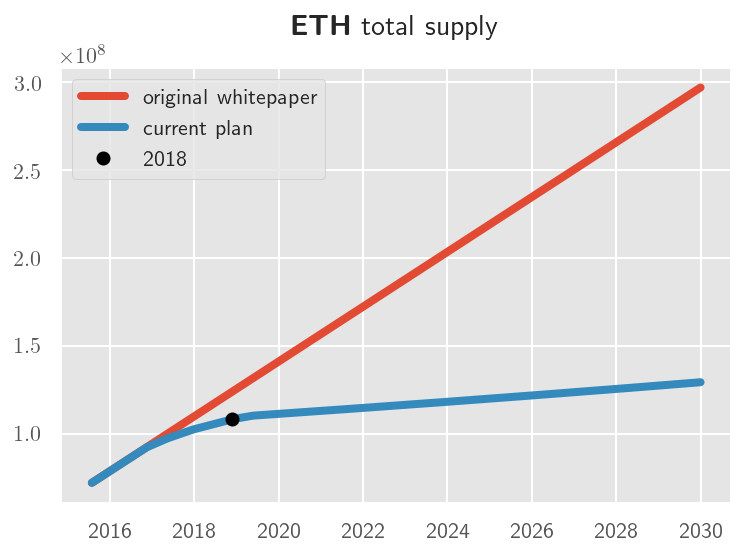

In [98]:
mask = eth_supply.date < datetime.datetime(2030, 1, 1)
plot_eth_supply_curve(eth_supply[mask], max_size=mask.sum(), out_name='ETH_zoom');

### XRP

In [111]:
def datetime_xrp_supply_curve():
    supply = [
        # Total distribution,
        # Datetime,
    ]
    start_date = datetime.datetime(2018, 12, 1)
    escrow_cue = [1e9] * 52
    y = 40 * 1e9
    supply.append([y])
    for _ in range(400):
        xrp = escrow_cue.pop(0)
        y += (xrp / 2)
        escrow_cue.append(xrp / 2)
        supply.append([y])
    
    df = pd.DataFrame(
        supply, columns=['total_supply']
    )
    df['total_supply_pct'] = (
        df['total_supply'] / df['total_supply'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq='MS',
        periods=len(df)
    )
    return df

def plot_supply_curve(
    supply,
    coin_name,
    plot_pct=True,
    max_size=10000,
    ):
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    if plot_pct:
        values = supply.total_supply_pct.values[::step_size]
    else:
        values = supply.total_supply.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt='-',
        lw=4,
        label='supply curve',
    )
    
    # Plot current date
    mask = supply.date > datetime.datetime.now()
    current_supply = supply[mask].iloc[0]
    dates = mpl.dates.date2num([current_supply.date])
    if plot_pct:
        values = [current_supply.total_supply_pct]
    else:
        values = [current_supply.total_supply]
    plt.plot(
        dates,
        values,
        'o',
        color='black',
        ms=6,
        label=current_supply.date.strftime('%Y'),
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ total supply',
        y=1.05
    )
    plt.legend()
    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
    plt.savefig(
        f'../charts/{coin_name}.png',
        bbox_inches='tight',
        dpi=300
    )
    return plt


<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

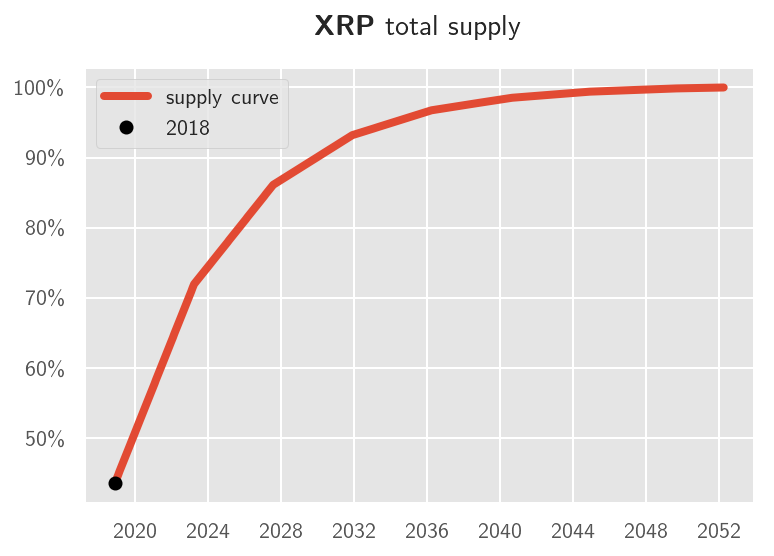

In [114]:
xrp_supply = datetime_xrp_supply_curve()

plot_supply_curve(
    xrp_supply,
    'XRP',
    max_size=len(xrp_supply),
)